# Tutorial for fitting P3D data

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/lya_pk/


## Load data

In [2]:
from lya_pk.archive import GadgetArchive3D
from lya_pk.utils import params_numpy2dict

In [4]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program,
    folder_data=folder_lya_data,
    #     force_recompute_plin=True,
)
print(
    len(Archive3D.training_data),
    Archive3D.rel_err_p3d.shape,
    Archive3D.rel_err_p1d.shape,
)

1650 (20, 16) (676,)
CPU times: user 10.4 s, sys: 621 ms, total: 11.1 s
Wall time: 11.3 s


In [4]:
file = np.load(
    "/home/jchaves/Proyectos/projects/lya/lya_pk/data/mpg_hypercube_plin.npz"
)
file_ind_snap = file["ind_snap"]
file_sim_label = file["sim_label"]
file_val_scaling = file["val_scaling"]

In [5]:
file.files

['Plin', 'Plin_for_p1d', 'ind_snap', 'sim_label', 'val_scaling']

In [ ]:
_ind = np.argwhere(
    (archive[ind_book]["ind_snap"] == file_ind_snap)
    & (archive[ind_book]["sim_label"] == file_sim_label)
    & (archive[ind_book]["val_scaling"] == file_val_scaling)
)[0, 0]

In [11]:
file["ind_snap"]

array([ 0,  1,  2, ...,  8,  9, 10])

In [12]:
file["sim_label"]

array(['mpg_0', 'mpg_0', 'mpg_0', ..., 'mpg_9', 'mpg_9', 'mpg_9'],
      dtype='<U6')

In [12]:
np.round(file["val_scaling"][44], 3)

1.1

In [3]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program, folder_data=folder_lya_data, average="axes"
)
print(
    len(Archive3D.training_data),
    Archive3D.rel_err_p3d.shape,
    Archive3D.rel_err_p1d.shape,
)

3300 (20, 16) (676,)
CPU times: user 11.2 s, sys: 441 ms, total: 11.7 s
Wall time: 11.7 s


In [5]:
Archive3D.training_data[0].keys()

dict_keys(['ind_axis', 'ind_phase', 'sim_label', 'ind_rescaling', 'ind_snap', 'cosmo_params', 'kp_Mpc', 'z', 'dkms_dMpc', 'Delta2_p', 'n_p', 'alpha_p', 'f_p', 'mF', 'p3d_Mpc', 'k3d_Mpc', 'mu3d', 'T0', 'gamma', 'sigT_Mpc', 'kF_Mpc', 'k_Mpc', 'p1d_Mpc', 'val_scaling', 'Arinyo', 'Arinyo_25', 'Arinyo_75', 'Plin', 'Plin_for_p1d', 'Arinyo_minin', 'model'])

## Plot

In [27]:
sample = Archive3D.training_data

<IPython.core.display.Javascript object>


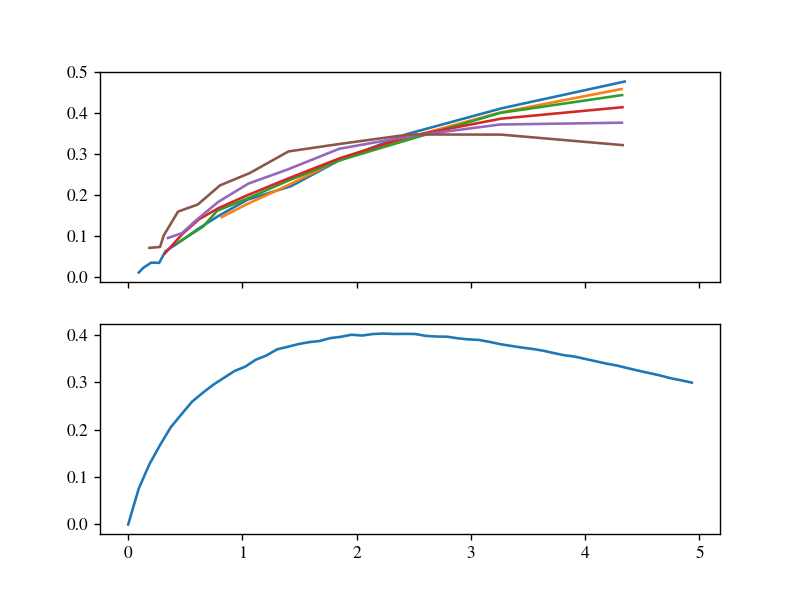

In [28]:
fig, ax = plt.subplots(2, 1, sharex=True)

ii = 0

xx = sample[ii]["k3d_Mpc"]
yy = sample[ii]["p3d_Mpc"]
mask = np.argwhere(xx[:, 0] < 5)[:, 0]
norm = xx**3 / (2 * np.pi**2)

for jj in range(0, 16, 3):
    ax[0].plot(xx[mask, jj], yy[mask, jj] * norm[mask, jj])

xx = sample[ii]["k_Mpc"]
yy = sample[ii]["p1d_Mpc"]
mask = np.argwhere(xx < 5)[:, 0]
norm = xx / np.pi

ax[1].plot(xx[mask], yy[mask] * norm[mask])

## Fit P3D

In [5]:
def get_default_params():
    seed_params = {
        "bias": 0.12,
        "beta": 1.4,
        "q1": 0.4,
        "kvav": 0.6,
        "av": 0.3,
        "bv": 1.5,
        "kp": 18.0,
        "q2": 0.2,
    }
    priors = {
        "bias": [0, 2],
        "beta": [0, 5.0],
        "q1": [0, 5],
        "kvav": [0.1, 5.0],
        "av": [0, 2],
        "bv": [0, 5],
        "kp": [1, 50],
        "q2": [0, 5],
    }
    return seed_params, priors

In [6]:
seed_params, priors = get_default_params()

In [7]:
def get_input_data(data, rel_err_p3d, rel_err_p1d):
    data_dict = {}
    data_dict["units"] = "N"
    data_dict["z"] = np.atleast_1d(data["z"])
    data_dict["k3d"] = data["k3d_Mpc"]
    data_dict["mu3d"] = data["mu3d"]
    data_dict["p3d"] = data["p3d_Mpc"] * data["k3d_Mpc"] ** 3 / 2 / np.pi**2
    data_dict["std_p3d"] = rel_err_p3d * data_dict["p3d"]

    data_dict["k1d"] = data["k_Mpc"]
    data_dict["p1d"] = data["p1d_Mpc"] * data["k_Mpc"] / np.pi
    data_dict["std_p1d"] = rel_err_p1d * data_dict["p1d"]

    return data_dict

In [8]:
ind_book = 0
data_dict = get_input_data(
    Archive3D.training_data[ind_book],
    Archive3D.rel_err_p3d,
    Archive3D.rel_err_p1d,
)

In [9]:
sim_label = Archive3D.training_data[ind_book]["sim_label"]
scale_tau = Archive3D.training_data[ind_book]["val_scaling"]
ind_z = Archive3D.training_data[ind_book]["z"]

In [ ]:
Archive3D.add_Arinyo_model(Archive3D.data)

In [10]:
from lya_pk.fit_p3d import FitPk

In [18]:
kmax_3d = 5
noise_3d = 0.02
kmax_1d = 5
noise_1d = 0.01
fit_type = "both"

fit3d = FitPk(
    data_dict,
    Archive3D.training_data[ind_book]["model"],
    fit_type=fit_type,
    k3d_max=kmax_3d,
    k1d_max=kmax_1d,
    noise_3d=noise_3d,
    noise_1d=noise_1d,
    priors=priors,
)

KeyError: 'model'

In [12]:
%%time
r1, r2 = fit3d.maximize_likelihood(seed_params)

/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in su

CPU times: user 4.59 s, sys: 89 ms, total: 4.68 s
Wall time: 4.68 s


In [16]:
Archive3D.training_data[ind_book]["Arinyo"]

{'bias': -0.7233493616106809,
 'beta': 0.29508756063207053,
 'q1': 1.3659581975742738,
 'kvav': 2.1543869709857524,
 'av': 0.6817457982386057,
 'bv': 2.0106469976032217,
 'kp': 16.784030451466812,
 'q2': 0.41001867701435957}

In [17]:
r2

{'bias': 0.6857921501218547,
 'beta': 0.3690664858914199,
 'q1': 1.8659075717584324,
 'kvav': 1.7804735696653757,
 'av': 0.5189580064803436,
 'bv': 1.8384969088520051,
 'kp': 16.292034118930378,
 'q2': 0.0016311797661307682}

In [15]:
fit3d.get_chi2(r2)

6.714276990283115

In [25]:
from scipy.optimize import minimize

minus_log_like = lambda *args: -fit3d._log_like(*args)

In [94]:
# seed_params = Archive3D.training_data[ind_book]["Arinyo"]
names = list(seed_params.keys())
seed_val = np.array(list(seed_params.values()))
# seed_val[0] *= -1

In [79]:
# get max likelihood values
# results = minimize(
#     minus_log_like,
#     seed_val,
#     args=(names),
#     method="Nelder-Mead",
#     options={"maxiter": 10000, "fatol": 1e-7},
# )

In [95]:
params_in = seed_val
chi2_in = fit3d.get_chi2(params_numpy2dict(params_in))

In [96]:
%%time

for it in range(10):
    if it != 0:
        chi2_in = chi2_out * 1

    results = minimize(
        minus_log_like,
        params_in,
        args=(names),
        method="BFGS",
    )

    params_in = results.x
    chi2_out = fit3d.get_chi2(params_numpy2dict(params_in))
    print(it, chi2_in, chi2_out)

    if np.abs(chi2_in - chi2_out) < 0.1:
        break

/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in su

0 11043.61264181213 14.497469588678898


/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


1 14.497469588678898 7.128676555162057


/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


2 7.128676555162057 6.722900147559267


/home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


3 6.722900147559267 6.714276990283115
CPU times: user 4.38 s, sys: 63.5 ms, total: 4.45 s
Wall time: 4.45 s


In [89]:
fit3d.get_chi2(params_numpy2dict(results.x))

6.714276990283115

In [74]:
results

      fun: 3.4145161088034226
 hess_inv: array([[ 1.72607985e-03, -2.41532403e-03, -2.96354878e-02,
        -2.81140708e-03,  4.08943906e-04, -1.59769494e-03,
        -1.46036654e-02,  4.00986357e-02],
       [-2.41532403e-03,  6.60760153e-03,  3.21543135e-02,
        -1.40996646e-02, -6.22332580e-03,  3.08116695e-03,
        -4.99745152e-02, -3.38811265e-02],
       [-2.96354878e-02,  3.21543135e-02,  5.95641532e-01,
         1.02457395e-01,  1.10481322e-02,  3.45578979e-02,
         6.39441482e-01, -8.98844507e-01],
       [-2.81140708e-03, -1.40996646e-02,  1.02457395e-01,
         1.62740298e-01,  5.33402949e-02, -1.25234596e-02,
         7.02003652e-01, -2.30478481e-01],
       [ 4.08943906e-04, -6.22332580e-03,  1.10481322e-02,
         5.33402949e-02,  2.60937477e-02,  2.38777893e-02,
         2.94332240e-01, -6.58428729e-02],
       [-1.59769494e-03,  3.08116695e-03,  3.45578979e-02,
        -1.25234596e-02,  2.38777893e-02,  1.65574639e-01,
         2.32183113e-02, -1.24860494

In [67]:
results2 = minimize(
    minus_log_like,
    results2.x,
    args=(names),
    method="Nelder-Mead",
    options={"maxiter": 10000, "fatol": 1e-7},
)

In [68]:
results2

 final_simplex: (array([[7.71350553e-01, 3.10159383e-01, 5.12549720e-11, 1.16198902e+00,
        2.96748539e-01, 1.82350881e+00, 1.23821018e+01, 3.22139841e+00],
       [7.71351554e-01, 3.10157234e-01, 5.12594519e-11, 1.16199363e+00,
        2.96755916e-01, 1.82352024e+00, 1.23821652e+01, 3.22137051e+00],
       [7.71350921e-01, 3.10159446e-01, 5.12616941e-11, 1.16197619e+00,
        2.96739822e-01, 1.82351198e+00, 1.23820354e+01, 3.22140535e+00],
       [7.71351267e-01, 3.10157987e-01, 5.12595400e-11, 1.16198617e+00,
        2.96747215e-01, 1.82351637e+00, 1.23820917e+01, 3.22138549e+00],
       [7.71351070e-01, 3.10158685e-01, 5.12664180e-11, 1.16198692e+00,
        2.96756803e-01, 1.82354170e+00, 1.23821472e+01, 3.22137204e+00],
       [7.71351147e-01, 3.10156979e-01, 5.12561330e-11, 1.16199504e+00,
        2.96753330e-01, 1.82351776e+00, 1.23821122e+01, 3.22138789e+00],
       [7.71350868e-01, 3.10160097e-01, 5.12546663e-11, 1.16198921e+00,
        2.96749790e-01, 1.82351161e+00, 1

In [60]:
results.x

array([7.90730467e-01, 3.04780125e-01, 1.65260664e-03, 9.82159780e-01,
       3.92806424e-01, 1.99025365e+00, 1.53061904e+01, 2.49170783e+00])

In [62]:
numpy2

{'bias': -0.7233493616106809,
 'beta': 0.29508756063207053,
 'q1': 1.3659581975742738,
 'kvav': 2.1543869709857524,
 'av': 0.6817457982386057,
 'bv': 2.0106469976032217,
 'kp': 16.784030451466812,
 'q2': 0.41001867701435957}

In [75]:
fit3d.get_chi2(params_numpy2dict(results.x))

6.829032217606845

In [63]:
fit3d.get_chi2(Archive3D.training_data[ind_book]["Arinyo"])

7.4551954209321165

In [19]:
r1

 final_simplex: (array([[4.61104684e-01, 2.42109764e+00, 9.44028721e-03, 1.31275262e-01,
        2.60317445e-01, 7.23300522e-01, 2.05952121e+01, 3.49571881e-12],
       [4.61104610e-01, 2.42109702e+00, 9.44030135e-03, 1.31274911e-01,
        2.60317796e-01, 7.23297032e-01, 2.05952667e+01, 1.56625384e-11],
       [4.61104634e-01, 2.42109695e+00, 9.44014801e-03, 1.31275217e-01,
        2.60317858e-01, 7.23299420e-01, 2.05952447e+01, 9.37837570e-12],
       [4.61104674e-01, 2.42109735e+00, 9.44016339e-03, 1.31275371e-01,
        2.60317637e-01, 7.23301049e-01, 2.05952165e+01, 1.34383471e-11],
       [4.61104759e-01, 2.42110014e+00, 9.44064114e-03, 1.31274748e-01,
        2.60316535e-01, 7.23296399e-01, 2.05952190e+01, 2.24683913e-11],
       [4.61104656e-01, 2.42109804e+00, 9.44039143e-03, 1.31274849e-01,
        2.60317418e-01, 7.23296604e-01, 2.05952557e+01, 4.05868325e-11],
       [4.61104805e-01, 2.42109882e+00, 9.44032311e-03, 1.31275749e-01,
        2.60316790e-01, 7.23305604e-01, 2

In [23]:
r1

 final_simplex: (array([[-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.73934767,  0.31382333,  1.38656266,  2.03703852,  0.64724181,
         2.06971075, 17.8627298 ,  0.44417492],
       [-0.7393

In [15]:
r2

{'bias': 0.46110468381154235,
 'beta': 2.421097641275459,
 'q1': 0.009440287207904036,
 'kvav': 0.1312752620532042,
 'av': 0.26031744468230755,
 'bv': 0.7233005221532167,
 'kp': 20.59521213970676,
 'q2': 3.495718809224994e-12}

In [20]:
seed_params

{'bias': 0.12,
 'beta': 1.4,
 'q1': 0.4,
 'kvav': 0.6,
 'av': 0.3,
 'bv': 1.5,
 'kp': 18.0,
 'q2': 0.2}

<IPython.core.display.Javascript object>


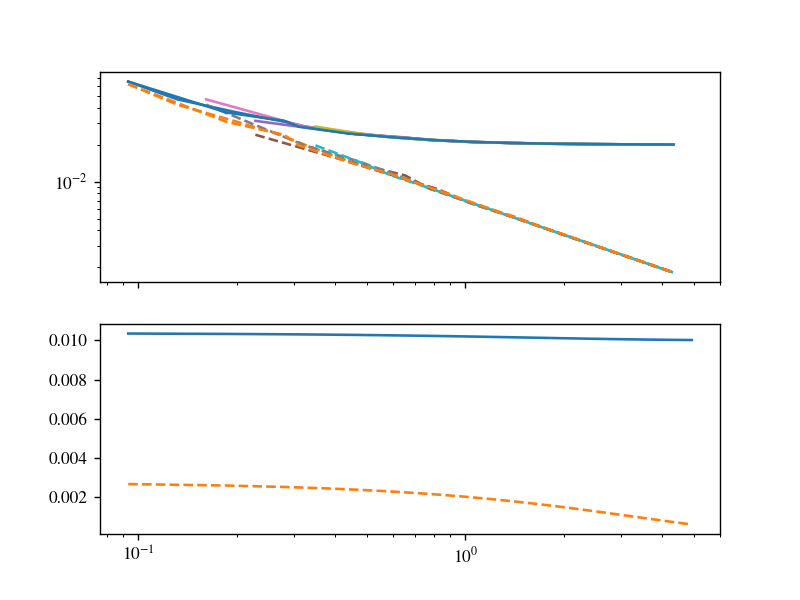

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True)

# xx = Archive3D.training_data[ind_book]["k3d_Mpc"]
# yy = Archive3D.training_data[ind_book]["p3d_Mpc"]
# mask = np.argwhere(xx[:, 0] < 5)[:, 0]
# norm = xx**3 / (2 * np.pi**2)

for jj in range(0, 16, 3):
    mask = fit3d.ind_fit3d[:, jj]
    #     ax[0].errorbar(
    #         fit3d.data["k3d"][mask, jj],
    #         fit3d.data["p3d"][mask, jj],
    #         fit3d.data["std_p3d"][mask, jj],
    #     )
    ax[0].plot(
        fit3d.data["k3d"][mask, jj],
        fit3d.data["std_p3d"][mask, jj] / fit3d.data["p3d"][mask, jj],
    )
    ax[0].plot(
        fit3d.data["k3d"][mask, jj],
        fit3d.data["std_p3d_sta"][mask, jj] / fit3d.data["p3d"][mask, jj],
        "--",
    )


# ax[1].errorbar(
#     fit3d.data["k1d"][fit3d.ind_fit1d],
#     fit3d.data["p1d"][fit3d.ind_fit1d],
#     fit3d.data["std_p1d"][fit3d.ind_fit1d],
# )
ax[1].plot(
    fit3d.data["k1d"][fit3d.ind_fit1d],
    fit3d.data["std_p1d"][fit3d.ind_fit1d]
    / fit3d.data["p1d"][fit3d.ind_fit1d],
)
ax[1].plot(
    fit3d.data["k1d"][fit3d.ind_fit1d],
    fit3d.data["std_p1d_sta"][fit3d.ind_fit1d]
    / fit3d.data["p1d"][fit3d.ind_fit1d],
    "--",
)

In [13]:
# predP3D = Archive3D.training_data[ii]["model"].P3D_Mpc(
#     data_dict["z"], data_dict["k3d"], data_dict["mu3d"]
# )

In [101]:
# %%time
# lnprob, chain = fit3d.explore_likelihood(
#     seed_params,
#     seed=0,
#     nwalkers=500,
#     nsteps=1250,
#     nburn=750,
#     plot=False,
#     attraction=0.4,
# )

<IPython.core.display.Javascript object>


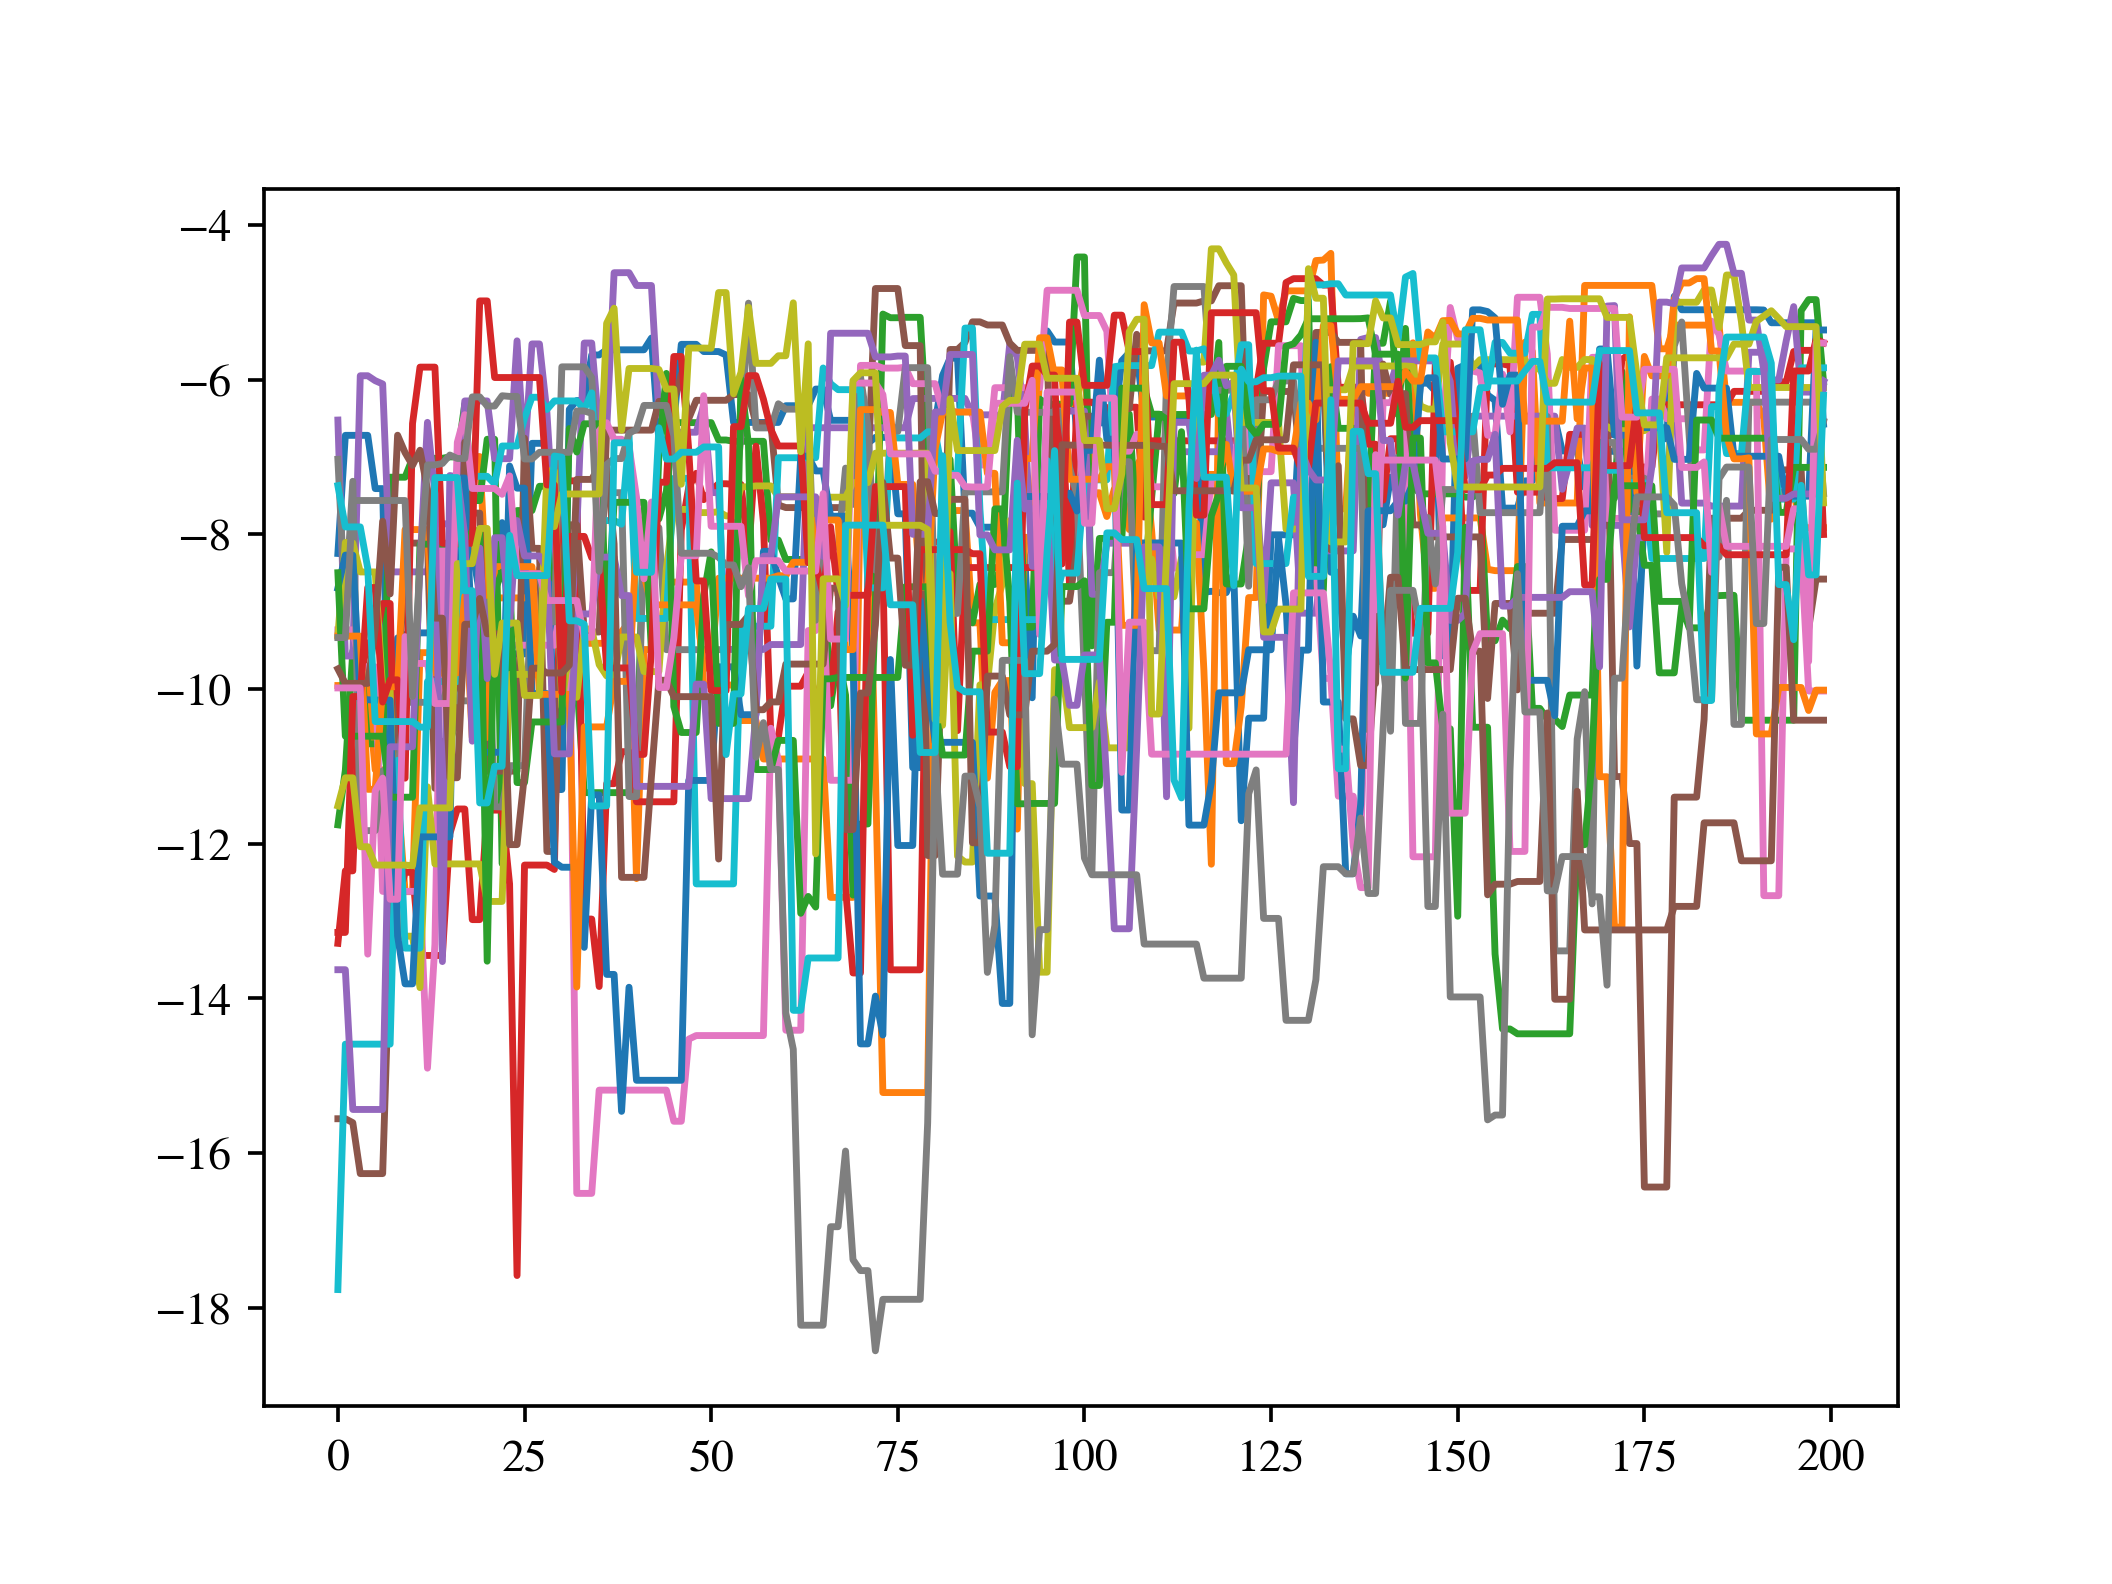

CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s


In [26]:
%%time
lnprob, chain = fit3d.explore_likelihood(
    seed_params,
    seed=0,
    nwalkers=20,
    nsteps=300,
    nburn=100,
    plot=True,
    attraction=0.4,
)

In [32]:
params_ml = chain[np.argmax(lnprob)]
params_ml

array([ 0.73203871,  0.33177446,  1.04901747,  1.50531558,  0.51935738,
        1.90273893, 16.2135202 ,  1.06554276])

In [31]:
params_ml = np.median(chain, axis=0)
params_ml

array([ 0.713782  ,  0.37047834,  1.14182571,  1.48518292,  0.47378027,
        1.67856255, 16.9708412 ,  1.12385091])

In [29]:
#script to launch!

SyntaxError: invalid syntax (2795775970.py, line 1)

In [12]:
params_ml = np.array(
    [
        0.88897565,
        0.53278372,
        0.24920322,
        1.50281468,
        0.30663262,
        4.73473679,
        27.69733292,
        0.0,
    ]
)

In [33]:
chain.shape

(3200, 8)

In [35]:
from corner import corner

<IPython.core.display.Javascript object>


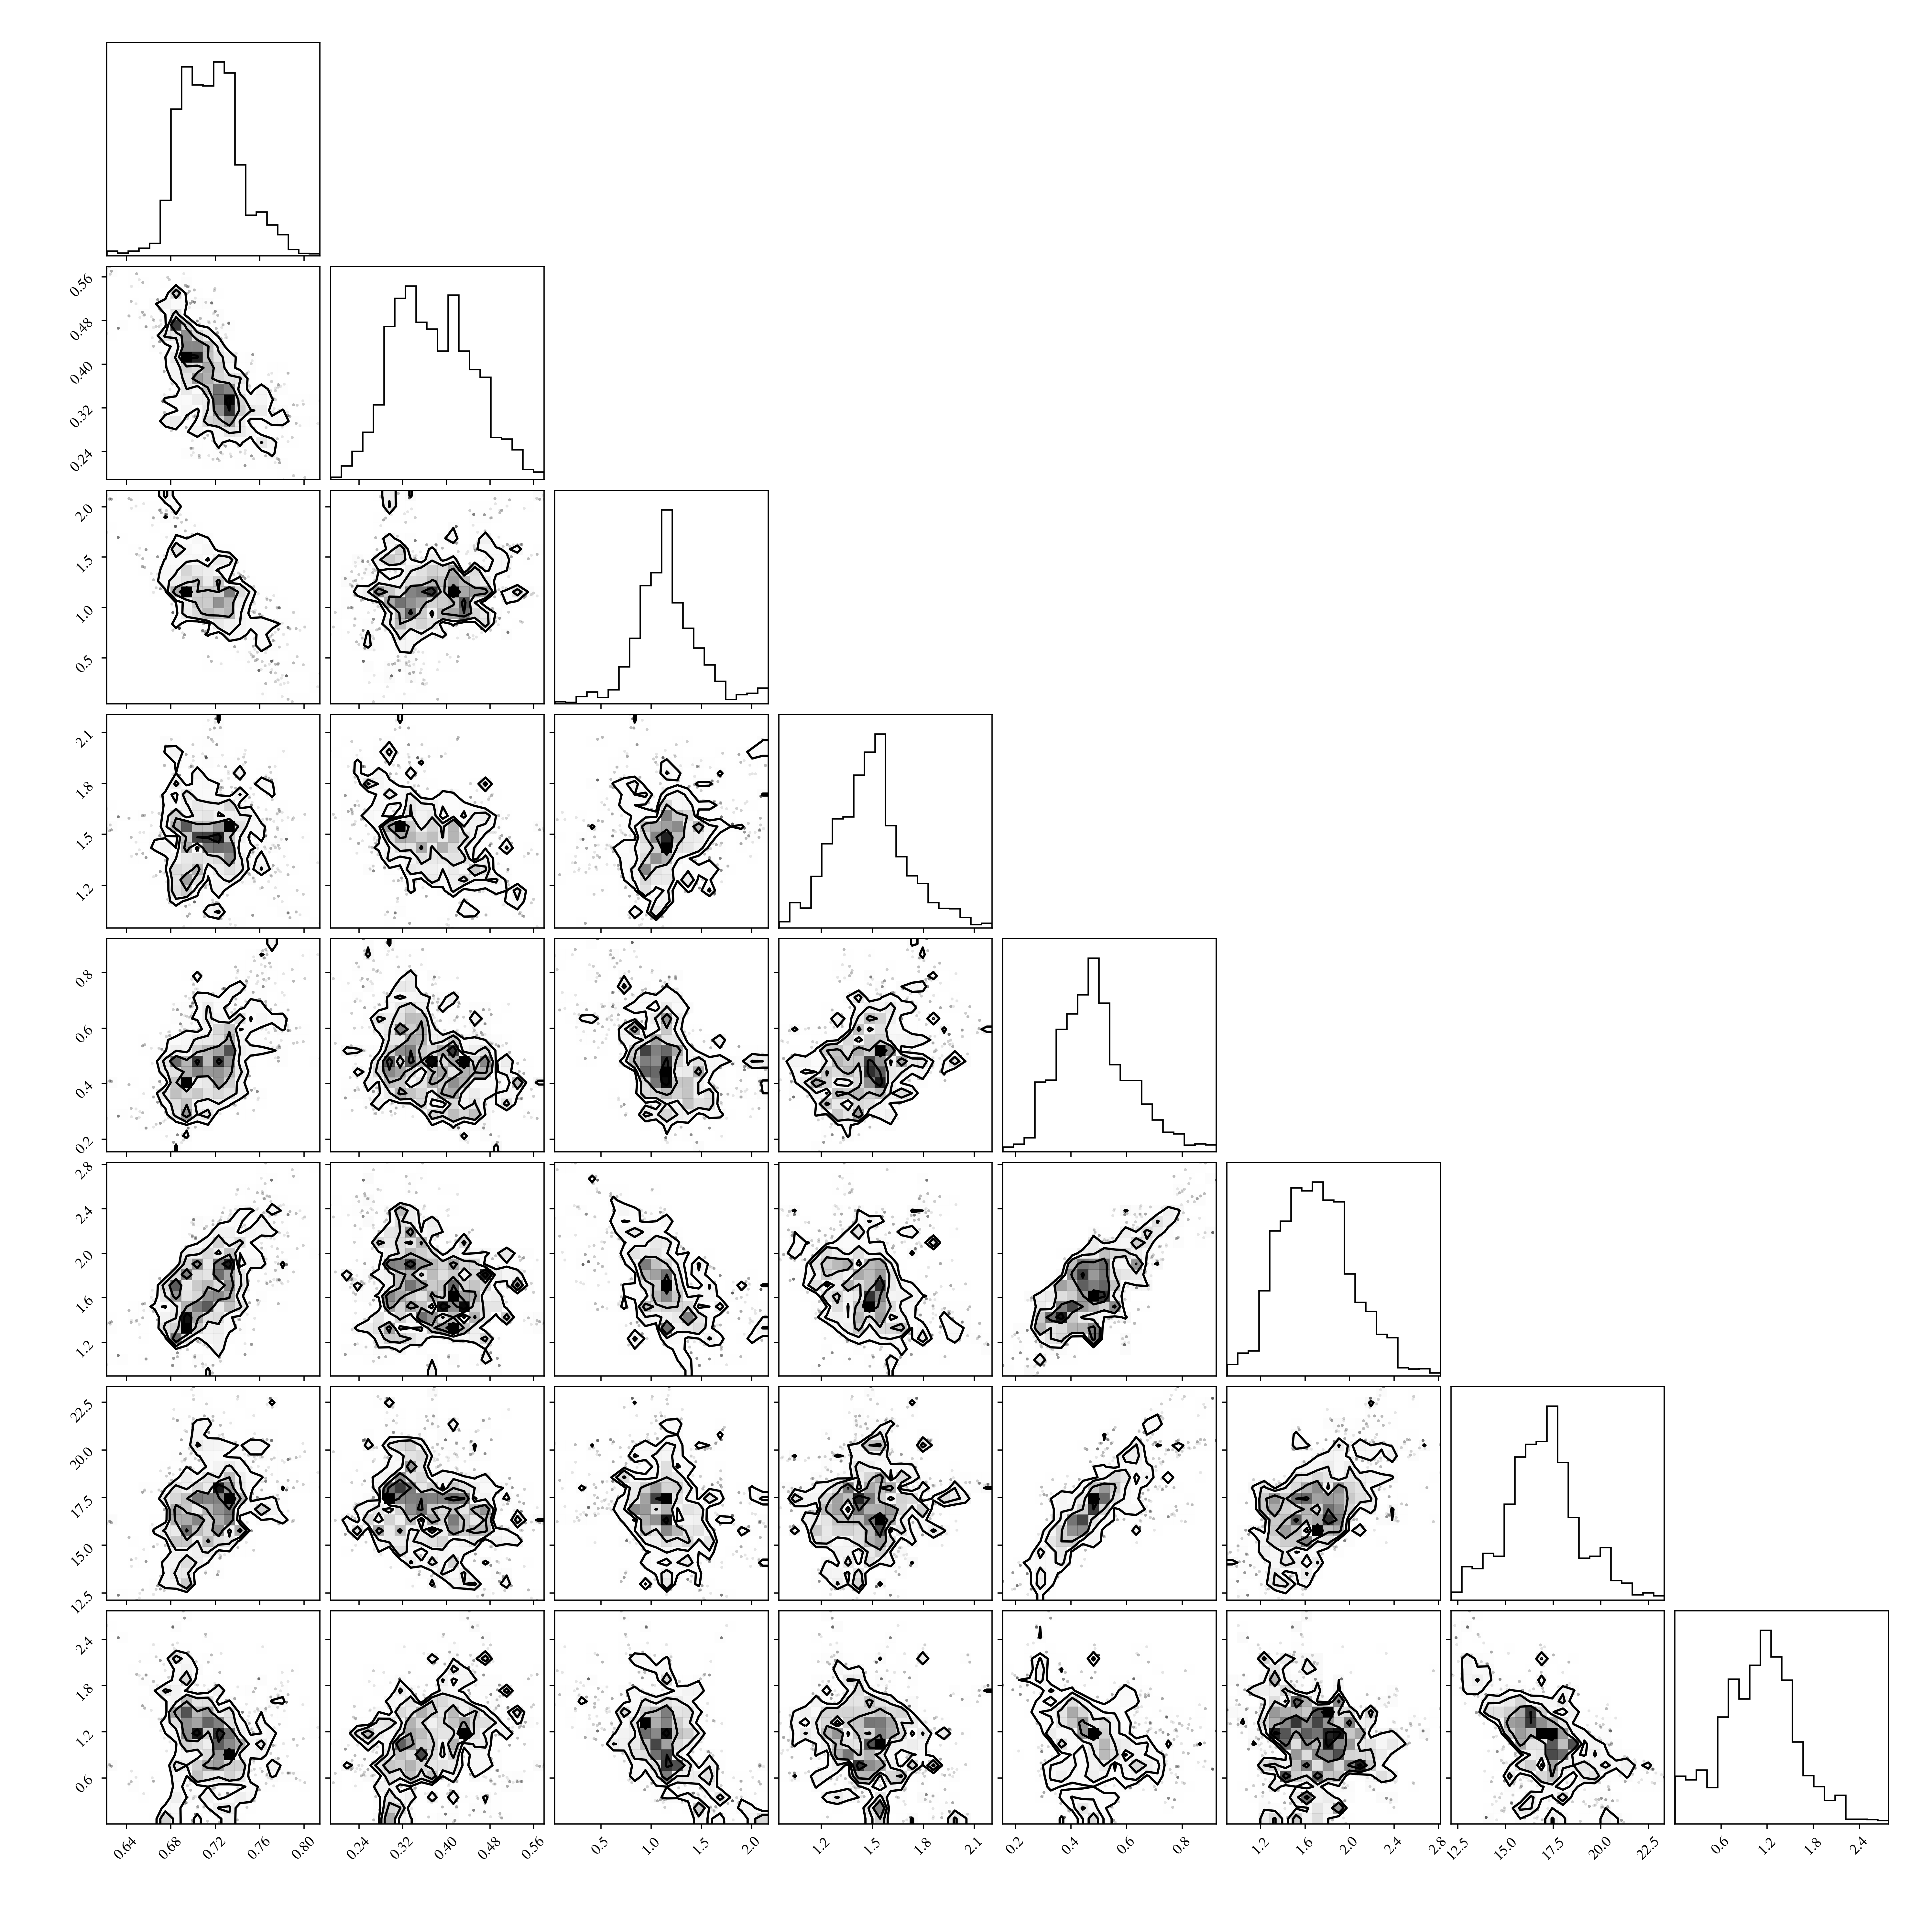

In [36]:
corner(chain);

In [109]:
ind_book

0

In [110]:
fit3d.data.keys()

dict_keys(['units', 'z', 'k3d', 'mu3d', 'p3d', 'std_p3d', 'k1d', 'p1d', 'std_p1d', 'std_p3d_sta', 'std_p3d_sys', 'std_p1d_sta', 'std_p1d_sys'])

In [37]:
params_numpy2dict(params_ml)

{'bias': 0.7320387124437943,
 'beta': 0.33177446256943693,
 'q1': 1.0490174693791046,
 'kvav': 1.5053155760658898,
 'av': 0.5193573771287076,
 'bv': 1.9027389331072722,
 'kp': 16.21352020413233,
 'q2': 1.0655427550261942}

In [38]:
params_ml2 = params_ml.copy()
# params_ml2[6] = 5
# params_ml2[2] = 1e1

# params_ml2[6] = 2

<IPython.core.display.Javascript object>


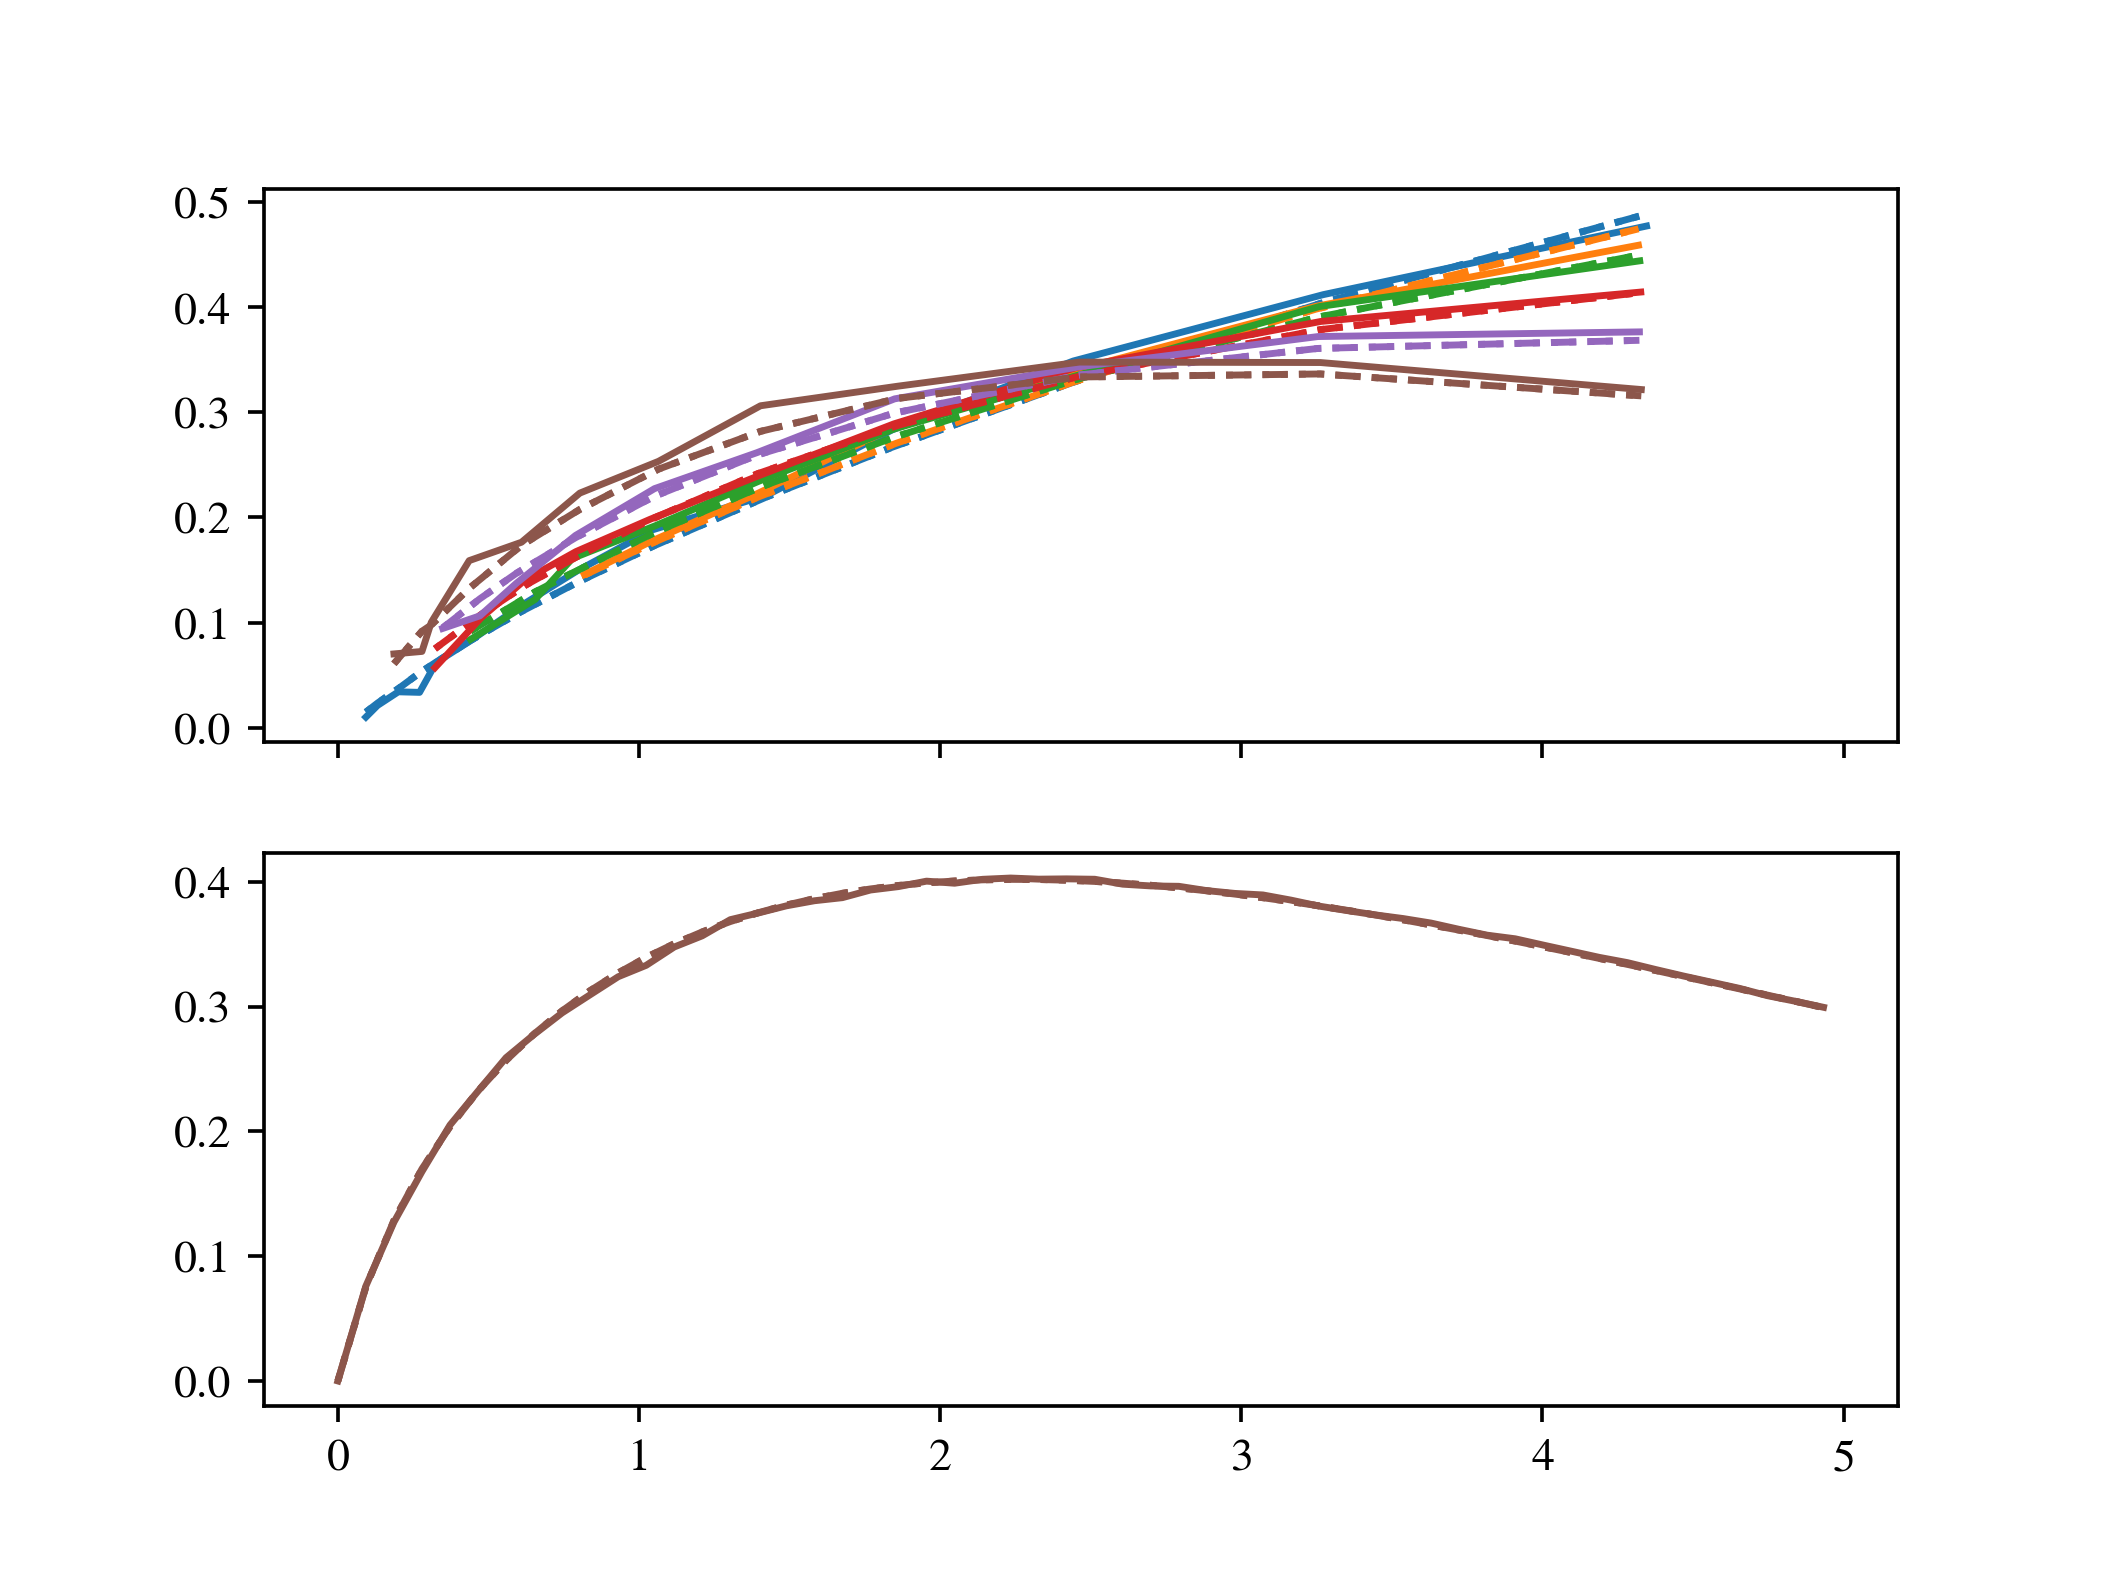

False
True


In [39]:
fig, ax = plt.subplots(2, 1, sharex=True)

xx = Archive3D.training_data[ind_book]["k3d_Mpc"]
yy = Archive3D.training_data[ind_book]["p3d_Mpc"]
yy0 = fit3d.get_model_3d(params_numpy2dict(params_ml))
yy1 = fit3d.get_model_3d(params_numpy2dict(params_ml2))
print(np.allclose(yy0, yy1))
mask = np.argwhere(xx[:, 0] < 5)[:, 0]
norm = xx**3 / (2 * np.pi**2)

ii0 = 0
for jj in range(0, 16, 3):
    col = "C" + str(ii0)
    ax[0].plot(xx[mask, jj], yy[mask, jj] * norm[mask, jj], col)
    ax[0].plot(xx[mask, jj], yy0[mask, jj], col + "--")
    ax[0].plot(xx[mask, jj], yy1[mask, jj], col + ":")
    ii0 += 1


xx = Archive3D.training_data[ind_book]["k_Mpc"]
yy = Archive3D.training_data[ind_book]["p1d_Mpc"]
yy0 = fit3d.get_model_1d(params_numpy2dict(params_ml))
yy1 = fit3d.get_model_1d(params_numpy2dict(params_ml2))
print(np.allclose(yy0, yy1))
mask = np.argwhere(xx < 5)[:, 0]
norm = xx / np.pi

ax[1].plot(xx[mask], yy[mask] * norm[mask], col)
ax[1].plot(xx[mask], yy0[mask], col + "--")
ax[1].plot(xx[mask], yy1[mask], col + ":")

In [6]:
ii = 0
mask = (Archive3D.training_data[ii]["k_Mpc"] < 5) & (
    Archive3D.training_data[ii]["k_Mpc"] > 0
)

In [7]:
%%time
ii = 0
for jj in range(500):
    p1d = Archive3D.training_data[ii]["model"].P1D_Mpc(
        np.atleast_1d(3), Archive3D.training_data[ii]["k_Mpc"][mask]
    )

CPU times: user 738 ms, sys: 229 µs, total: 738 ms
Wall time: 737 ms


In [ ]:
here! 1.86

In [8]:
%%time
for jj in range(1000):
    _ = Archive3D.training_data[ii]["model"].P3D_Mpc(
        np.atleast_1d(2),
        Archive3D.training_data[ii]["k3d_Mpc"],
        Archive3D.training_data[ii]["mu3d"],
    )

CPU times: user 337 ms, sys: 86 µs, total: 337 ms
Wall time: 336 ms


In [66]:
plt.plot(Archive3D.training_data[ii]["k_Mpc"][mask], p1d)

In [119]:
plt.close()

/tmp/ipykernel_208193/1332255292.py:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


In [2]:
from lya_pk.model_p3d_arinyo import ArinyoModel
from lace.cosmo.camb_cosmo import get_cosmology
from lya_pk.emulator_p3d import P3DEmulator

In [3]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program, folder_data=folder_lya_data
)
print(len(Archive3D.training_data))
rerr_p3d = Archive3D.rel_err_p3d

1650
CPU times: user 11.5 s, sys: 209 ms, total: 11.7 s
Wall time: 11.7 s


In [4]:
import torch, random

olr = 1e-3
obs = 50
oss = 75
og = 0.1
owd = 0.01
ohid = 2
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
oepochs = 100

In [5]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    rerr_p3d=Archive3D.rel_err_p3d,
    target_space="p3d",
    nepochs=oepochs,
    lr=olr,
    batch_size=obs,
    step_size=oss,
    gamma=og,
    weight_decay=owd,
    nhidden=ohid,
    adamw=True,
)

Emualtor trained in 6.374593019485474 seconds


35.314083099365234


<IPython.core.display.Javascript object>


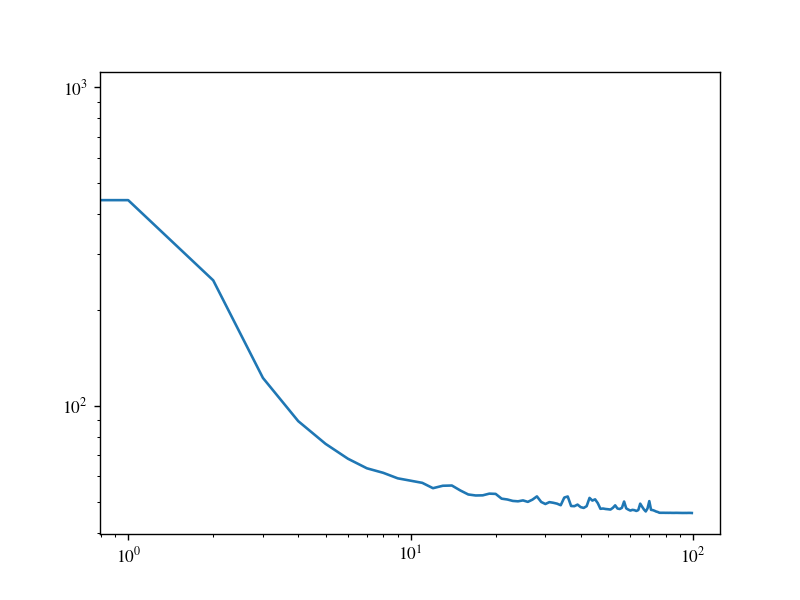

In [6]:
burnin = 0
arr = np.array(p3d_emu.loss_arr)
print(np.min(arr))
plt.plot(np.mean(arr, axis=1)[burnin:])

In [7]:
testing_data = Archive3D.get_testing_data("mpg_central")

In [8]:
arr = np.zeros(11)
zz = np.zeros(11)
mF = np.zeros(11)
for ii in range(11):
    _ = testing_data[ii]["k3d_Mpc"][:, 0] < 4
    zz[ii] = testing_data[ii]["z"]
    mF[ii] = testing_data[ii]["mF"]
    arr[ii] = np.nanmean(
        testing_data[ii]["p3d_Mpc"][_, :] / testing_data[ii]["Plin"][_, :]
    )

<IPython.core.display.Javascript object>


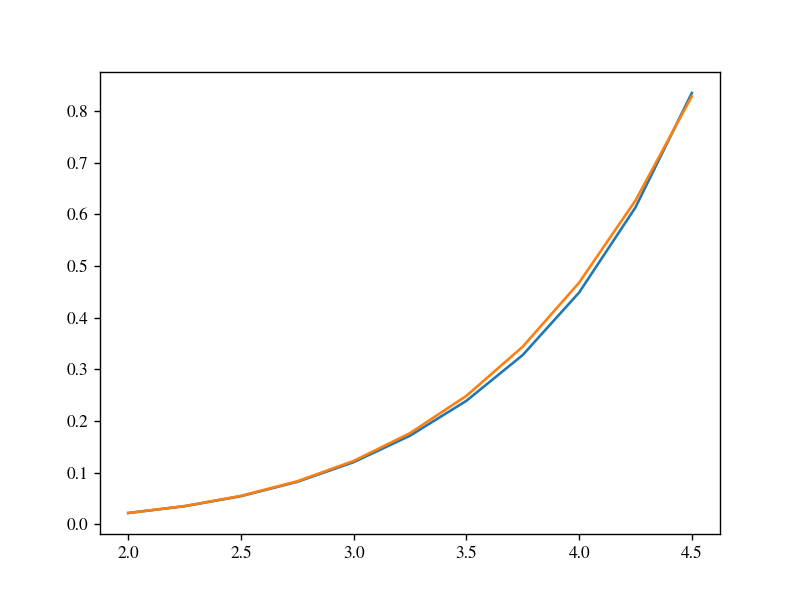

In [9]:
plt.plot(zz, arr)
yy = (1 + zz) ** 6
plt.plot(zz, yy / yy[-1] * arr[-1])

1.0


<IPython.core.display.Javascript object>


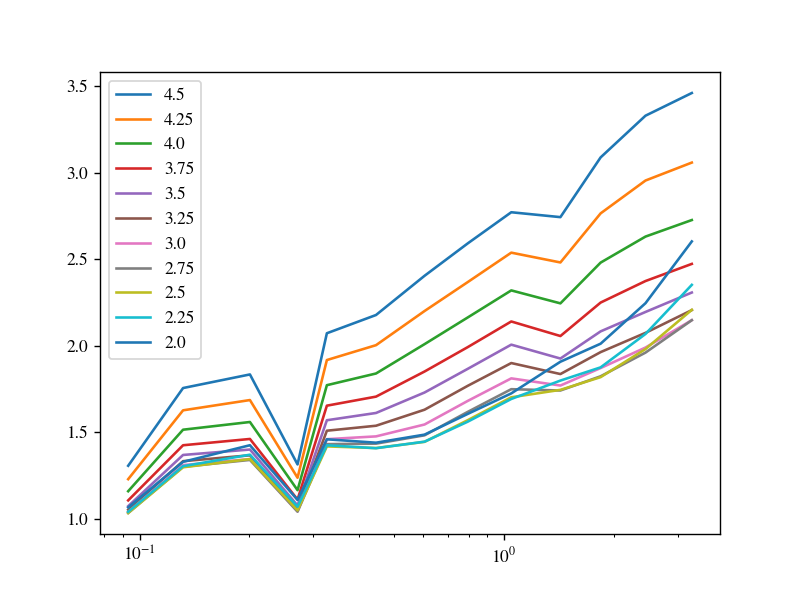

0.7564490529115283
0.5644739300537774
0.4149402084517553
0.2999845898617095
0.21289106930272228
0.14797345392001743
0.10046423217998138
0.06640979339689686
0.04257199759138974
0.02633609568058904


In [14]:
arr = np.zeros(11)
for ii in range(11):
    #     print(1 / testing_data[ii]["mF"], testing_data[ii]["z"])
    norm = (1 + testing_data[ii]["z"]) ** 6
    #     norm = (1 / testing_data[ii]["mF"]) ** 2 * (1 + testing_data[ii]["z"]) ** 2
    if ii == 0:
        norm0 = norm * 1
    print(norm / norm0)
    _ = testing_data[ii]["k3d_Mpc"][:, 0] < 4
    xx = testing_data[ii]["k3d_Mpc"][_, 0]
    yy = (
        testing_data[ii]["p3d_Mpc"][_, 0]
        / testing_data[ii]["Plin"][_, 0]
        / norm
    )
    if ii == 0:
        #         y0 = yy * 1
        y0 = 1e5
    plt.plot(xx, yy * y0, label=str(testing_data[ii]["z"]))
plt.legend()
plt.xscale("log")

In [103]:

from lya_pk.likelihood import Likelihood
from lya_pk.plots_v0 import params_numpy2dict

In [240]:
# in PIC
folder_chains = "/data/desi/scratch/jchavesm/p3d_fits_new/"
# local
folder_chains = (
    "/home/jchaves/Proyectos/projects/lya/data/pkfits/p3d_fits_new/"
)

for ind_book in range(1000, 1001):
    sim_label = Archive3D.training_data[ind_book]["sim_label"]
    scale_tau = Archive3D.training_data[ind_book]["val_scaling"]
    ind_z = Archive3D.training_data[ind_book]["z"]
    #     sim_label = "mpg_central"

    tag = (
        "fit_sim"
        + sim_label[4:]
        + "_tau"
        + str(np.round(scale_tau, 2))
        + "_z"
        + str(ind_z)
        + "_kmax3d"
        + str(Archive3D.kmax_3d)
        + "_noise3d"
        + str(Archive3D.noise_3d)
        + "_kmax1d"
        + str(Archive3D.kmax_1d)
        + "_noise1d"
        + str(Archive3D.noise_1d)
    )
    # check folder is not None
    file_arinyo = np.load(folder_chains + tag + ".npz")
    print(file_arinyo["best_params"])

[-0.09476058  1.86419653  0.57973902  0.57376356  0.25592165  1.49549389
 11.86481141  0.11263869]


In [241]:
nelem = 200
_ = file_arinyo['lnprob'] > np.percentile(file_arinyo['lnprob'], 70)
ind = np.arange(file_arinyo["chain"][_].shape[0])
ind_use = np.random.permutation(ind)[:nelem]
params_use = file_arinyo["chain"][_][ind_use]
params_use.shape

(200, 8)

In [242]:
indbest = np.argmax(file_arinyo['lnprob'])

In [243]:
# dataset = testing_data
dataset = Archive3D.training_data

In [244]:

params = dataset[ind_book]["Arinyo"].copy()
print(params)
# params = params_numpy2dict(file_arinyo['chain'][indbest])
# print(params)


{'bias': -0.09476057668885234, 'beta': 1.8641965333368349, 'd1_q1': 0.5797390196169432, 'd1_kvav': 0.5737635582121006, 'd1_av': 0.2559216510542335, 'd1_bv': 1.4954938891426477, 'd1_kp': 11.864811409407238, 'd1_q2': 0.11263869152994731}


In [245]:

like = Likelihood(
        dataset[ind_book], Archive3D.rel_err_p3d, Archive3D.rel_err_p1d
    )
# params = np.array(list(dataset[ind_book]["Arinyo"].values()))

In [246]:
# params['bias'] = 0.6
p3d_best1 = like.like.get_model_3d(parameters=params)

In [247]:
p3d_best2 = np.zeros((nelem, p3d_best1.shape[0], p3d_best1.shape[1]))
for ii in range(nelem):
    p3d_best2[ii] = like.like.get_model_3d(parameters=params_numpy2dict(params_use[ii]))
av_p3d = np.mean(p3d_best2, axis=0)

<IPython.core.display.Javascript object>


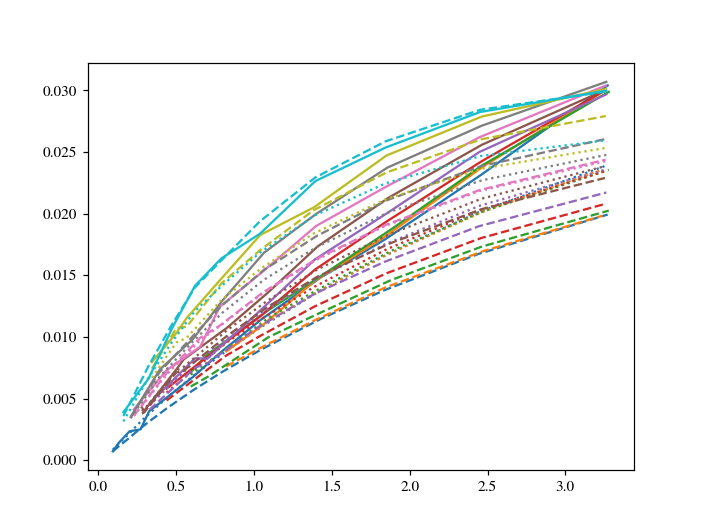

In [248]:
i0 = 0
for ii in range(10):
    col = 'C'+str(i0)
    kk = dataset[ind_book]["k3d_Mpc"][:, ii]
    _ = kk < 4
    norm = kk[_]**3/ (2 * np.pi**2)
#     norm = 1
    
    plt.plot(kk[_], 
             norm*dataset[ind_book]["p3d_Mpc"][_, ii], col+'-')
    plt.plot(kk[_], 
             p3d_best1[_, ii], col+'--')
    plt.plot(kk[_], 
             av_p3d[_, ii], col+':')
    i0+=1
    

In [33]:
plt.close()


<IPython.core.display.Javascript object>


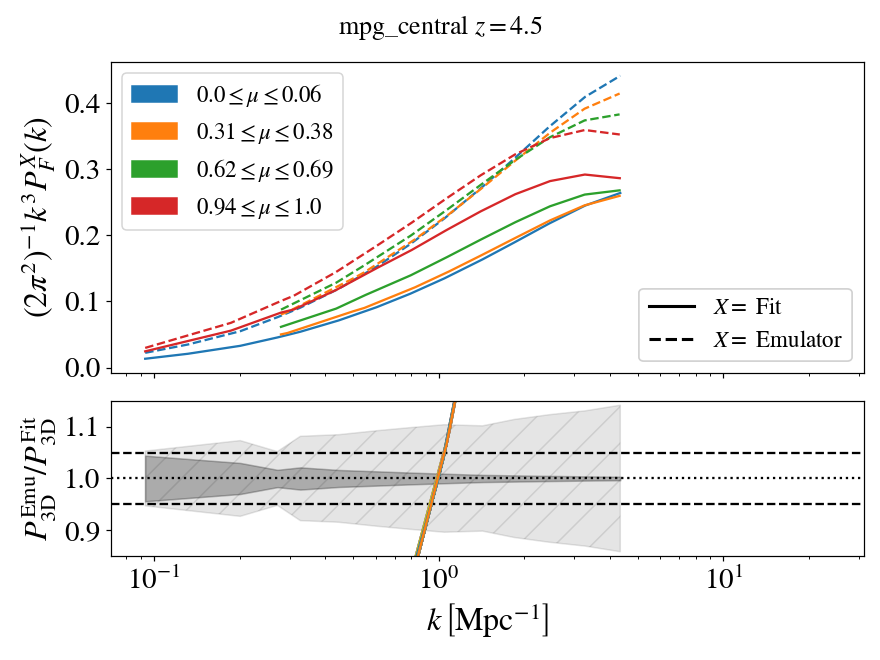

In [17]:
from lya_pk.plots_v0 import plot_test_p3d

sim_label = "mpg_central"
ind_book = 0
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

In [22]:
from lya_pk.likelihood import Likelihood

In [23]:
# load data
sim_label = "mpg_central"
testing_data = Archive3D.get_testing_data(sim_label)

# get params
input_params = np.zeros((len(testing_data), len(testing_data[0]["Arinyo"])))
predict_params = np.zeros_like(input_params)
zs = np.zeros((len(testing_data)))

for jj in range(len(testing_data)):
    zs[jj] = testing_data[jj]["z"]
    _cosmo_params = np.zeros(len(Archive3D.emu_params))
    for ii, par in enumerate(Archive3D.emu_params):
        _cosmo_params[ii] = testing_data[jj][par]
    predict_params[jj] = p3d_emu.get_coeff(_cosmo_params)
    input_params[jj] = list(testing_data[jj]["Arinyo"].values())

# make sure bias negative (dependence on bias square)
input_params[:, 0] = -np.abs(input_params[:, 0])

like = Likelihood(
    testing_data[ind_book], Archive3D.rel_err_p3d, Archive3D.rel_err_p1d
)

In [28]:
predict_params[0]

array([ 8.30079019e-01,  1.07220385e-10, -1.68899000e-01, -1.87556952e-01,
       -7.69184232e-02,  3.13400611e-10,  2.42033660e-01, -1.26461147e-10])

In [12]:
central = Archive3D.get_testing_data(sim_label="mpg_central")

In [13]:
p3d, p3derr = p3d_emu._get_p3D_Mpc(central, data_emu=None)

<IPython.core.display.Javascript object>


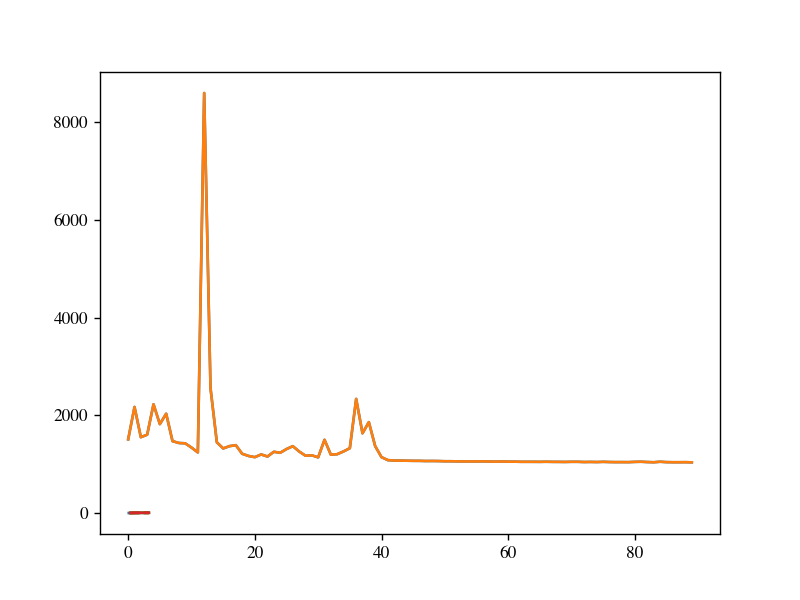

In [41]:
ii = 2
p3d_new = np.zeros_like(central[ii]["p3d_Mpc"])
p3d_new[p3d_emu.k_mask] = p3d[ii]

ukk = 0
for kk in range(0, 16, 4):
    col = "C" + str(ukk)
    ind = central[ii]["k3d_Mpc"][:, kk] < 4
    k = central[ii]["k3d_Mpc"][ind, kk]
    plt.plot(k, k**3 * central[ii]["p3d_Mpc"][ind, kk], col)
    plt.plot(k, k**3 * p3d_new[ind, kk], col + "--")
    ukk += 1

In [14]:
p3d0 = central[0]["p3d_Mpc"][p3d_emu.k_mask]

<IPython.core.display.Javascript object>


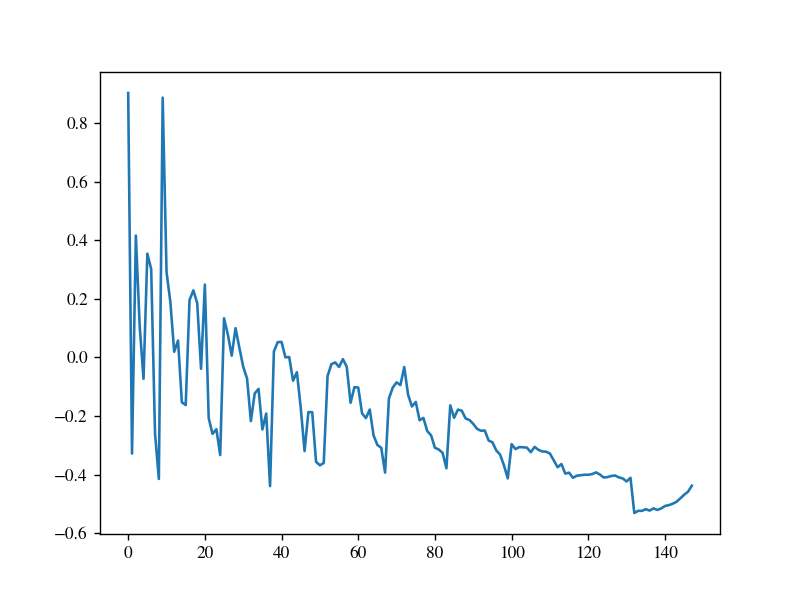

In [29]:
plt.plot(p3d[0] / p3d0 - 1)

Emualtor trained in 0.33761167526245117 seconds


bias, beta, q1, q2, av, bv, kvav, kp

In [205]:
data = [
    {
        key: value
        for key, value in p3d_emu.training_data[i].items()
        if key in p3d_emu.emuparams
    }
    for i in range(1)
]
data = p3d_emu._sort_dict(
    data, p3d_emu.emuparams
)  # sort the data by emulator parameters

data = [list(data[i].values()) for i in range(1)]
data = np.array(data)

In [206]:
data = (data - p3d_emu.paramLims[:, 0]) / (
    p3d_emu.paramLims[:, 1] - p3d_emu.paramLims[:, 0]
) - 0.5


In [207]:
test = torch.Tensor(data)

In [208]:
coeffs_Arinyo, coeffslogerr_Arinyo = p3d_emu.emulator(test.to(p3d_emu.device))

In [209]:
coeffs_Arinyo

tensor([[-6.5608e-01,  5.4229e-01, -7.7768e-02, -1.7079e-01,  1.9306e-03,
         -2.2808e-41, -4.7280e-41, -1.6418e-40]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [210]:
coeffs_Arinyo[:,0] = torch.clamp(coeffs_Arinyo[:,0] , -2, 2)
coeffs_Arinyo[:,1] = torch.clamp(coeffs_Arinyo[:,1] , 0.01, 3)
coeffs_Arinyo[:,2] = torch.clamp(coeffs_Arinyo[:,2] , 1e-15, 5)
coeffs_Arinyo[:,3] = torch.clamp(coeffs_Arinyo[:,3] , 1e-15, 5)
coeffs_Arinyo[:,6] = torch.clamp(coeffs_Arinyo[:,6] , 0.1, 5)
coeffs_Arinyo[:,4] = torch.clamp(coeffs_Arinyo[:,4] , 1e-5, 3)
coeffs_Arinyo[:,5] = torch.clamp(coeffs_Arinyo[:,5] , 0.5, 3)
coeffs_Arinyo[:,7] = torch.clamp(coeffs_Arinyo[:,7] , 5, 40)


In [211]:
coeffs_Arinyo_0 = p3d_emu.training_data[0]['Arinyo']
coeffs_Arinyo_0

{'bias': -0.7233493616106809,
 'beta': 0.29508756063207053,
 'd1_q1': 1.3659581975742738,
 'd1_kvav': 2.1543869709857524,
 'd1_av': 0.6817457982386057,
 'd1_bv': 2.0106469976032217,
 'd1_kp': 16.784030451466812,
 'd1_q2': 0.41001867701435957}

In [212]:
Plin_test = p3d_emu.training_data[0]['Plin'][p3d_emu.k_mask]

In [213]:
p3d, p3dstd = p3d_emu.P3D_Mpc(Plin_test, p3d_emu.kMpc_train, p3d_emu.mu_train, coeffs_Arinyo, coeffslogerr_Arinyo**2, epoch=3)


In [214]:
p3d0 = p3d_emu.training_data[0]['p3d_Mpc'][p3d_emu.k_mask]

In [215]:
p3d

tensor([[2.8891e+02, 6.8722e+02, 1.5717e+02, 1.4420e+02, 2.5396e+02, 6.8080e+01,
         7.8423e+01, 1.3122e+02, 1.9137e+02, 3.7489e+01, 3.9545e+01, 6.3864e+01,
         5.4179e+01, 6.4482e+01, 9.9576e+01, 8.3677e+01, 2.5245e+01, 2.7135e+01,
         3.4937e+01, 3.0275e+01, 3.6163e+01, 3.9947e+01, 4.4972e+01, 5.9394e+01,
         6.3471e+01, 1.2770e+01, 1.3877e+01, 1.1284e+01, 1.5757e+01, 2.0998e+01,
         1.3333e+01, 1.5606e+01, 1.9921e+01, 2.2305e+01, 2.0095e+01, 2.6018e+01,
         2.5122e+01, 3.0348e+01, 6.3291e+00, 6.7986e+00, 6.5139e+00, 8.9960e+00,
         6.3436e+00, 7.8292e+00, 9.6707e+00, 8.5325e+00, 1.2086e+01, 9.8952e+00,
         1.1781e+01, 1.2865e+01, 1.4088e+01, 1.4326e+01, 3.3138e+00, 3.1001e+00,
         4.5387e+00, 3.2582e+00, 4.8512e+00, 3.4043e+00, 4.1257e+00, 4.1441e+00,
         4.4692e+00, 4.7388e+00, 4.9835e+00, 5.1884e+00, 5.9422e+00, 6.3377e+00,
         7.2762e+00, 7.3187e+00, 1.6866e+00, 1.6844e+00, 1.5528e+00, 1.8051e+00,
         2.0169e+00, 1.7328e

In [216]:
p3d0

array([2.54899546e+02, 6.77852888e+02, 1.85737290e+02, 1.51552046e+02,
       2.72481470e+02, 8.38750232e+01, 8.02830370e+01, 1.37025857e+02,
       2.15434145e+02, 3.35115371e+01, 4.51397302e+01, 7.42143729e+01,
       5.54458627e+01, 6.04529224e+01, 1.01056384e+02, 6.59618820e+01,
       3.53231829e+01, 3.35237152e+01, 4.33049723e+01, 3.81142311e+01,
       3.37660276e+01, 4.41986868e+01, 5.11257450e+01, 5.95896287e+01,
       6.64808083e+01, 1.87545694e+01, 2.03027696e+01, 1.58859775e+01,
       1.94555999e+01, 2.63838092e+01, 1.62983866e+01, 1.92693008e+01,
       2.72757665e+01, 2.48748194e+01, 2.00636951e+01, 2.80302063e+01,
       2.32955128e+01, 3.78487769e+01, 1.03054025e+01, 1.04033595e+01,
       9.26640924e+00, 1.30650986e+01, 8.58240332e+00, 1.11503570e+01,
       1.26660835e+01, 1.16083849e+01, 1.85091575e+01, 1.20127674e+01,
       1.30038035e+01, 1.64300574e+01, 1.69106769e+01, 1.53608597e+01,
       5.87239807e+00, 5.16666385e+00, 7.51904722e+00, 5.23989866e+00,
      

In [19]:
central = Archive3D.get_testing_data(sim_label='mpg_central')

p3d, p3derr = p3d_emu._get_p3D_Mpc(central, data_emu=None)